#Testing the coefficients in a real simulation where the feedback is generated by the readout.

#This set has 50 trials (the others only 5)

In [20]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
import os
import scipy
from scipy import stats

import save_load_file as slf

# Main functions to the 2 joint arm simulation

In [2]:
from simulation_2DoF_Arm_physics import *
reload(sys.modules['simulation_2DoF_Arm_physics']) # Makes sure the interpreter is going to reload the module

<module 'simulation_2DoF_Arm_physics' from 'simulation_2DoF_Arm_physics.pyc'>

#Start of the simulation!

In [3]:
trajectories = [[[0.75,0.25],[0.0,0.5]],\
                [[0.25,0.60],[-0.25,0.60]],\
                [[-0.10,0.75],[-0.10,0.25]],\
                [[-0.75,0.50],[-0.40,0.00]]]

In [4]:
# First the arm parametres according to Joshi/Maass paper
aparams = {
    'l1' : 0.5, # metres
    'l2' : 0.5,
    'lc1' : 0.25,
    'lc2' : 0.25,
    'm1' : 1.0, # kg
    'm2' : 1.0,
    'i1' : 0.03, # kg*m*m
    'i2' : 0.03
}

In [5]:
# Total time spent during the movement (in seconds)
MT = 0.5
# Simulation time step (in seconds)
time_step = 2/1000.0
# Number of neurons at each input layer (defines the resolution of the system)
Ninput = 50

In [6]:
t_mov=numpy.arange(0, MT, time_step) # t starts in 0s and steps time_step(s) until reaches MT(s)

In [7]:
sim_set = "set_00"
base_dir = "2DofArm_simulation_data"

# Reads all the experiments to check which range of torques is necessary to control the arm
# These values are based ONLY in the 4 trajectories used!
torques_all_1 = numpy.array([]);
torques_all_2 = numpy.array([]);
number_of_trajectories = len(trajectories)
for i in range(1,number_of_trajectories+1):
    states,torques = slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/States_Torques_movement"+str(i)+".gzpickle")
    torques_all_1 = numpy.concatenate((torques_all_1,torques[:,0])) # torques joint 1
    torques_all_2 = numpy.concatenate((torques_all_2,torques[:,1])) # torques joint 2

In [8]:
# Creates the 50 possible discrete values of torques for each joint (probably will be different)
torques_values_1=numpy.linspace(torques_all_1.min(),torques_all_1.max(),num=50)
torques_values_2=numpy.linspace(torques_all_2.min(),torques_all_2.max(),num=50)

In [9]:
# Creates the 50 possible discrete values of angles for each joint
teta1_values=numpy.linspace(-numpy.pi/6,numpy.pi,num=50)
teta2_values=numpy.linspace(0,numpy.pi,num=50)

In [10]:
# These are the 50 possible values that the input neurons will represent (x,y) 
x_values=numpy.linspace(-1,1,num=50)
y_values=numpy.linspace(-1,1,num=50)

In [11]:
def generates_lsm_start(tji):
    xstart,ystart = trajectories[tji-1][0]
    xdest,ydest = trajectories[tji-1][1]


    # The original system, proposed by Joshi/Maass 2006 starts without any information about the current
    # position because the proprioceptive feedback comes only after a time delay.

    # Now I will add some noise
    # noise_sd = 0.1
    # xstart,ystart = xstart+numpy.random.normal(loc=0,scale=noise_sd),ystart+numpy.random.normal(loc=0,scale=noise_sd)
    # xdest,ydest = xdest+numpy.random.normal(loc=0,scale=noise_sd),ydest+numpy.random.normal(loc=0,scale=noise_sd)

    # print "Original:", trajectories[tji-1][0],trajectories[tji-1][1]
    # print "Noisy:",[xstart,ystart],[xdest,ydest]


    # Indexes of the normalized initial position values to use in the LSM simulation
    xstart_idx =  abs(x_values-xstart).argmin()
    ystart_idx =  abs(y_values-ystart).argmin()

    # Indexes of the normalized final position values to use in the LSM simulation
    xdest_idx =  abs(x_values-xdest).argmin()
    ydest_idx =  abs(y_values-ydest).argmin()

    (xstart_idx,ystart_idx),(xdest_idx,ydest_idx)


    # The input (one big neurongroup with 300 neurons) will be divided like this:
    # 6 groups of 50 neurons.
    # - Group 1: xdest => offset:0
    # - Group 2: ydest => offset:50
    # - Group 3: teta1 => offset:100
    # - Group 4: teta2 => offset:150
    # - Group 5: tau1  => offset:200
    # - Group 6: tau2  => offset:250

    ############# Using ONLY the initial (start) position
    # x_lsm = xstart_idx + 0
    # y_lsm = ystart_idx + 50

    ############# Using ONLY the final (dest) position
    x_lsm = xdest_idx + 0
    y_lsm = ydest_idx + 50
    return x_lsm,y_lsm,xstart,ystart,xdest,ydest

##Measuring the difference between the generated curves
$MeanDistance=\frac{1}{N} \sum \limits_{n=1}^{N}  \lVert P_{Ideal}(n)-P_{Test}(n) \rVert$

$TotalLength=\sum \limits_{n=1}^{N}  \lVert P_{Ideal}(n)-P_{Ideal}(n-1) \rVert$

$METRIC=\frac{MeanDistance}{TotalLength}$

In [12]:
def MY_METRIC(vec_orig,vec):
    
    # First I calculate the mean distance between all the (x,y) points
    mean_distance=(numpy.sqrt(((vec_orig-vec)**2).sum(axis=0).mean()))
    
    # Then the line integral (the length of the curve)
    line_integral=(numpy.sqrt(((vec_orig.T[1:]-vec_orig.T[:-1])**2).sum(axis=1))).sum()

    return mean_distance/line_integral

In [15]:
for tji in range(1,5):
    METRIC = numpy.zeros((3,3,50,2),dtype=float)
    for noiselevel in range(3):
        for decimationlevel in range(3):
            for run_number in range(1,51):

                x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji)

                torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")

                torques_original = numpy.array([torques_all_1[(tji-1)*250:(tji)*250],torques_all_2[(tji-1)*250:(tji)*250]])

                METRIC[noiselevel,decimationlevel,run_number-1,:]=MY_METRIC(numpy.array([numpy.arange(0,250,dtype=float),torques_original[0,:]]),numpy.array([numpy.arange(0,250,dtype=float),torques[:,0]])),\
                MY_METRIC(numpy.array([numpy.arange(0,250,dtype=float),torques_original[1,:]]),numpy.array([numpy.arange(0,250,dtype=float),torques[:,1]]))

    slf.save_to_file(METRIC,"./"+base_dir+"/"+sim_set+"/metric_torques_trajectory_"+str(tji)+".pickles")

In [14]:
tji=1
METRIC=slf.load_from_file("./"+base_dir+"/"+sim_set+"/metric_torques_trajectory_"+str(tji)+".pickles")
METRIC[0,0,4]

array([ 0.00188273,  0.00041501])

In [16]:
for tji in range(1,5):
    METRIC = numpy.zeros((3,3,50,1),dtype=float)
    for noiselevel in range(3):
        for decimationlevel in range(3):
            x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji)
            
            t_mov=numpy.arange(0, .5, 2.0/1000) # t starts in 0s and steps time_step(s) until reaches MT(s)

            # Generates the movements according to:
            # Flash, Tamar, and Neville Hogan. 1985
            H_path=cartesian_movement_generation_training(xstart, ystart, xdest, ydest, .5, t_mov)

            metric_traj = []
            
            for run_number in range(1,51):

                teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
                H,E = joints_to_hand(teta,aparams)
                METRIC[noiselevel,decimationlevel,run_number-1]= MY_METRIC(numpy.array([H_path[:,0],H_path[:,1]]),numpy.array([H[:,0][:len(H_path[:,0])],H[:,1][:len(H_path[:,0])]]))

    slf.save_to_file(METRIC,"./"+base_dir+"/"+sim_set+"/metric_trajectory_trajectory_"+str(tji)+".pickles")

In [16]:
tji=1
METRIC=slf.load_from_file("./"+base_dir+"/"+sim_set+"/metric_trajectory_trajectory_"+str(tji)+".pickles")
METRIC[0,0,0]

array([ 0.08473506])

#Verifying

In [68]:
# This is for the joint curves

tji=1

METRIC_t=slf.load_from_file("./"+base_dir+"/"+sim_set+"/metric_torques_trajectory_"+str(tji)+".pickles")
print "Mean values for noiselevel=0:", METRIC_t[0,:,:,0].mean(axis=1)

Mean values for noiselevel=0: [ 0.00334262  0.00678523  0.0160801 ]


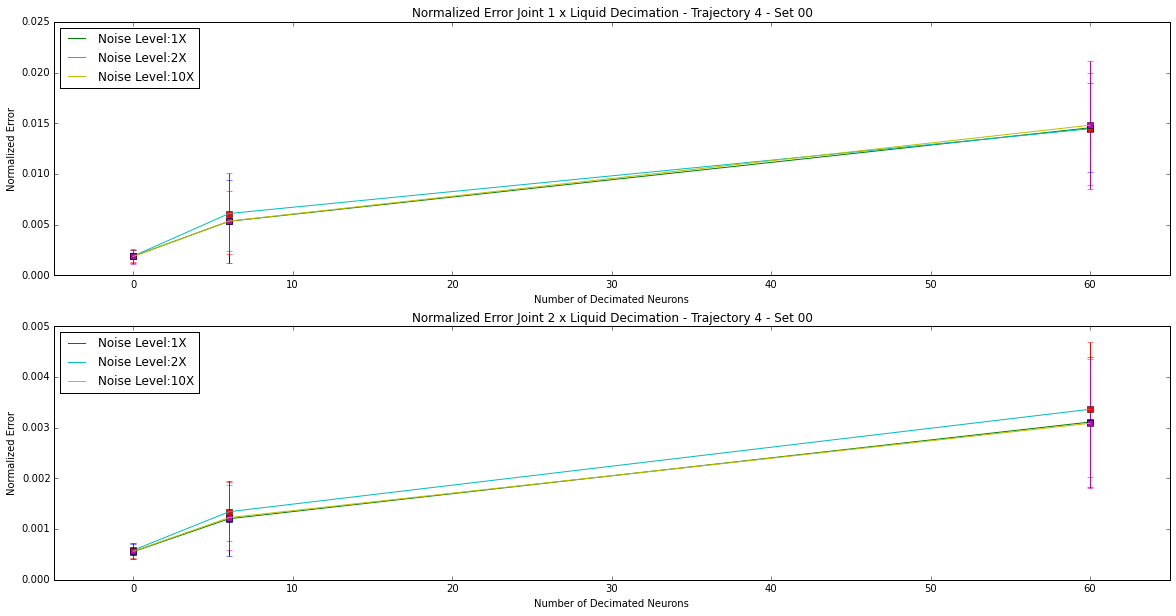

In [19]:
plt.figure(figsize =(20,10))
plt.subplot(211)
for noiselevel in range(3):
    plt.errorbar([0,6,60],METRIC_t[noiselevel,:,:,0].mean(axis=1), METRIC_t[noiselevel,:,:,0].std(axis=1), linestyle='None', marker='s')
    plt.plot([0,6,60],METRIC_t[noiselevel,:,:,0].mean(axis=1), label="Noise Level:"+str([1,2,10][noiselevel])+"X")
plt.xlim(-5,65)
# plt.ylim(0,.5)
plt.title("Normalized Error Joint 1 x Liquid Decimation - Trajectory "+str(tji)+" - Set " + sim_set[-2:])
plt.xlabel("Number of Decimated Neurons")
plt.ylabel("Normalized Error")
plt.legend(loc=0)

plt.subplot(212)
for noiselevel in range(3):
    plt.errorbar([0,6,60],METRIC_t[noiselevel,:,:,1].mean(axis=1), METRIC_t[noiselevel,:,:,1].std(axis=1), linestyle='None', marker='s')
    plt.plot([0,6,60],METRIC_t[noiselevel,:,:,1].mean(axis=1), label="Noise Level:"+str([1,2,10][noiselevel])+"X")
plt.xlim(-5,65)
# plt.ylim(0,.5)
plt.title("Normalized Error Joint 2 x Liquid Decimation - Trajectory "+str(tji)+" - Set " + sim_set[-2:])
plt.xlabel("Number of Decimated Neurons")
plt.ylabel("Normalized Error")
plt.legend(loc=0)
plt.show()

In [70]:
print "Is the noise making any difference in the joint curves?"

print "Joint 1"
print "decimationlevel=0:",scipy.stats.f_oneway(METRIC_t[0,0,:,0],METRIC_t[1,0,:,0],METRIC_t[2,0,:,0])
print "decimationlevel=1:",scipy.stats.f_oneway(METRIC_t[0,1,:,0],METRIC_t[1,1,:,0],METRIC_t[2,1,:,0])
print "decimationlevel=2:",scipy.stats.f_oneway(METRIC_t[0,2,:,0],METRIC_t[1,2,:,0],METRIC_t[2,2,:,0])

print "Joint 2"
print "decimationlevel=0:",scipy.stats.f_oneway(METRIC_t[0,0,:,1],METRIC_t[1,0,:,1],METRIC_t[2,0,:,1])
print "decimationlevel=1:",scipy.stats.f_oneway(METRIC_t[0,1,:,1],METRIC_t[1,1,:,1],METRIC_t[2,1,:,1])
print "decimationlevel=2:",scipy.stats.f_oneway(METRIC_t[0,2,:,1],METRIC_t[1,2,:,1],METRIC_t[2,2,:,1])

Is the noise making any difference in the joint curves?
Joint 1
decimationlevel=0: (0.36957971988365956, 0.69166493061060919)
decimationlevel=1: (0.68163548884228498, 0.50738044708445096)
decimationlevel=2: (4.3053010617316652, 0.015238567383996988)
Joint 2
decimationlevel=0: (0.71831825564764518, 0.48927484944638955)
decimationlevel=1: (0.79658654633696169, 0.45280178200235488)
decimationlevel=2: (0.87271740699003431, 0.41996795700317091)


In [74]:
# Now, I'm test two by two using the Kolmogorov-Smirnov test to verify if the means are the same. 
# Small p-value indicates different means (rejects the null hypotesis mean1=mean2)
print "Joint curve 1"
print "Decimation 6, no-noise vs 2x noise:",scipy.stats.ks_2samp(METRIC_t[0,1,:,0].flatten(), METRIC_t[1,1,:,0].flatten())
print "Decimation 6, no-noise vs 10x noise:",scipy.stats.ks_2samp(METRIC_t[0,1,:,0].flatten(), METRIC_t[2,1,:,0].flatten())
print "Decimation 6, 2x vs 10x noise:",scipy.stats.ks_2samp(METRIC_t[1,1,:,0].flatten(), METRIC_t[2,1,:,0].flatten())

print "Joint curve 2"
print "Decimation 6, no-noise vs 2x noise:",scipy.stats.ks_2samp(METRIC_t[0,1,:,1].flatten(), METRIC_t[1,1,:,1].flatten())
print "Decimation 6, no-noise vs 10x noise:",scipy.stats.ks_2samp(METRIC_t[0,1,:,1].flatten(), METRIC_t[2,1,:,1].flatten())
print "Decimation 6, 2x vs 10x noise:",scipy.stats.ks_2samp(METRIC_t[1,1,:,1].flatten(), METRIC_t[2,1,:,1].flatten())

Joint curve 1
Decimation 6, no-noise vs 2x noise: (0.26000000000000001, 0.056045859714424606)
Decimation 6, no-noise vs 10x noise: (0.22000000000000003, 0.15462946123059945)
Decimation 6, 2x vs 10x noise: (0.15999999999999992, 0.50765795335732711)
Joint curve 2
Decimation 6, no-noise vs 2x noise: (0.14000000000000001, 0.67793689645204447)
Decimation 6, no-noise vs 10x noise: (0.20000000000000001, 0.24079199341891797)
Decimation 6, 2x vs 10x noise: (0.12, 0.84094804639075904)


In [75]:
# This is for the trajectory

METRIC=slf.load_from_file("./"+base_dir+"/"+sim_set+"/metric_trajectory_trajectory_"+str(tji)+".pickles")


METRIC[0,:,:].mean(axis=1)

array([[ 0.04980899],
       [ 0.13640937],
       [ 0.24762721]])

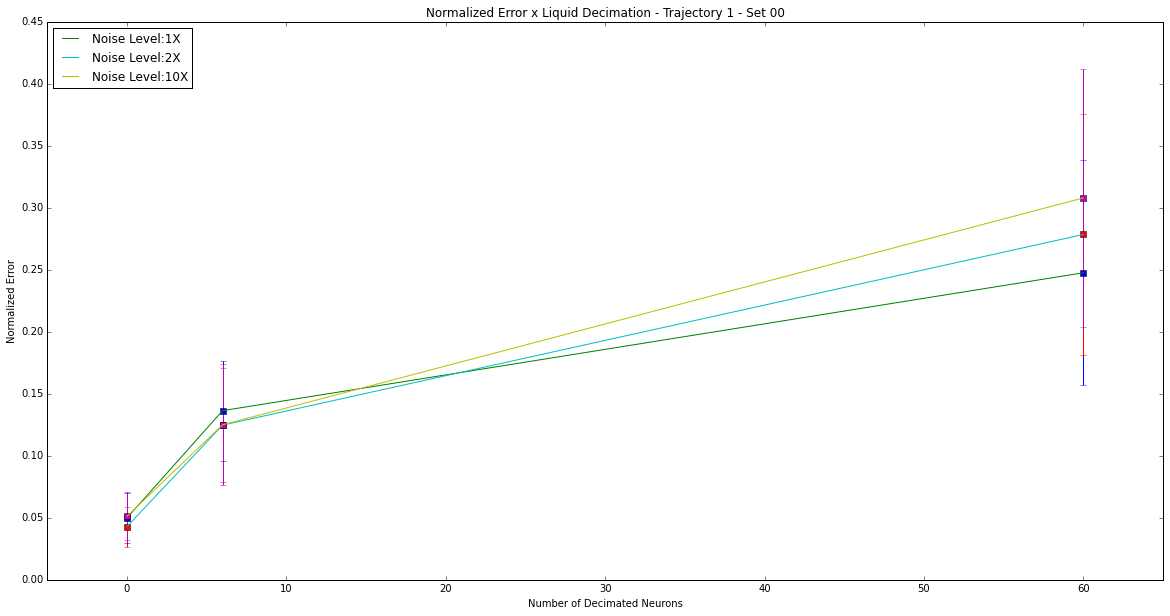

In [76]:
plt.figure(figsize =(20,10))
for noiselevel in range(3):
    plt.errorbar([0,6,60],METRIC[noiselevel,:,:].mean(axis=1), METRIC[noiselevel,:,:].std(axis=1)/numpy.sqrt(len(METRIC[noiselevel,:,:])), linestyle='None', marker='s')
    plt.plot([0,6,60],METRIC[noiselevel,:,:].mean(axis=1), label="Noise Level:"+str([1,2,10][noiselevel])+"X")
plt.xlim(-5,65)
# plt.ylim(0,.5)
plt.title("Normalized Error x Liquid Decimation - Trajectory "+str(tji)+" - Set " + sim_set[-2:])
plt.xlabel("Number of Decimated Neurons")
plt.ylabel("Normalized Error")
plt.legend(loc=0)
plt.show()

In [81]:
print "Is the noise making any difference in the trajectories?"

print "decimationlevel=0:",scipy.stats.f_oneway(METRIC[0,0,:].flatten(),METRIC[1,0,:].flatten(),METRIC[2,0,:].flatten())
print "decimationlevel=1:",scipy.stats.f_oneway(METRIC[0,1,:].flatten(),METRIC[1,1,:].flatten(),METRIC[2,1,:].flatten())
print "decimationlevel=2:",scipy.stats.f_oneway(METRIC[0,2,:].flatten(),METRIC[1,2,:].flatten(),METRIC[2,2,:].flatten())

Is the noise making any difference in the trajectories?
decimationlevel=0: (0.91751497870144361, 0.40178609432470869)
decimationlevel=1: (0.35216629461611249, 0.70375478592152274)
decimationlevel=2: (1.5680506358227184, 0.21191746967491043)


In [83]:
# Verifying if the distributions are normal (null hypotesis):
# Small p-values indicates they are not normal
for i in range(3):
    for j in range(3):
        print '(%d-%d)'%(i,j), 'normaltest teststat = %6.3f pvalue = %6.4f' % scipy.stats.normaltest(METRIC[i,j,:].flatten())

(0-0) normaltest teststat =  9.172 pvalue = 0.0102
(0-1) normaltest teststat =  9.311 pvalue = 0.0095
(0-2) normaltest teststat =  7.382 pvalue = 0.0250
(1-0) normaltest teststat = 18.120 pvalue = 0.0001
(1-1) normaltest teststat = 18.214 pvalue = 0.0001
(1-2) normaltest teststat =  8.181 pvalue = 0.0167
(2-0) normaltest teststat = 14.654 pvalue = 0.0007
(2-1) normaltest teststat =  9.661 pvalue = 0.0080
(2-2) normaltest teststat =  5.315 pvalue = 0.0701


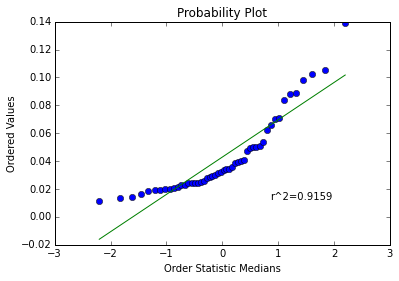

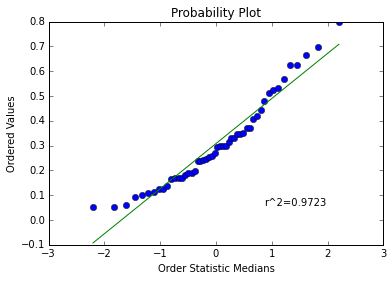

In [85]:
# Because of the big number of independent noise sources, the central limit theorem gives us reasons 
# to think the values are normally distributed...

# Just to visually confirm the normal test above
scipy.stats.probplot(METRIC[1,0,:].flatten(), sparams=(), dist='norm', fit=True, plot=plt);
plt.show()
scipy.stats.probplot(METRIC[2,2,:].flatten(), sparams=(), dist='norm', fit=True, plot=plt);

In [86]:
# Now, I'm test two by two using the ttest to verify if the means are the same. 
# Small p-value indicates different means (rejects the null hypotesis mean1=mean2)
print "Decimation 6, no-noise vs 2x noise:",scipy.stats.ttest_ind(METRIC[0,1,:].flatten(), METRIC[1,1,:].flatten())
print "Decimation 6, no-noise vs 10x noise:",scipy.stats.ttest_ind(METRIC[0,1,:].flatten(), METRIC[2,1,:].flatten())
print "Decimation 6, 2x vs 10x noise:",scipy.stats.ttest_ind(METRIC[1,1,:].flatten(), METRIC[2,1,:].flatten())

Decimation 6, no-noise vs 2x noise: (0.767447187148665, 0.44466077690613059)
Decimation 6, no-noise vs 10x noise: (0.72558265431784497, 0.46982383515738457)
Decimation 6, 2x vs 10x noise: (-0.016268562450357935, 0.98705321270047597)


In [87]:
# Now, I'm test two by two using the Kolmogorov-Smirnov test to verify if the means are the same. 
# Small p-value indicates different means (rejects the null hypotesis mean1=mean2)
print "Decimation 6, no-noise vs 2x noise:",scipy.stats.ks_2samp(METRIC[0,1,:].flatten(), METRIC[1,1,:].flatten())
print "Decimation 6, no-noise vs 10x noise:",scipy.stats.ks_2samp(METRIC[0,1,:].flatten(), METRIC[2,1,:].flatten())
print "Decimation 6, 2x vs 10x noise:",scipy.stats.ks_2samp(METRIC[1,1,:].flatten(), METRIC[2,1,:].flatten())

Decimation 6, no-noise vs 2x noise: (0.16000000000000003, 0.50765795335732633)
Decimation 6, no-noise vs 10x noise: (0.22000000000000003, 0.15462946123059945)
Decimation 6, 2x vs 10x noise: (0.080000000000000016, 0.99584488300247898)


##Loads the coefficients generated by the linear regression:

In [24]:
[c_tau1,r_tau1] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_tau1_08-05-15.pickle")
[c_tau2,r_tau2] = slf.load_from_file("./"+base_dir+"/"+sim_set+"/coefficients_residues_tau2_08-05-15.pickle")
r_tau1,r_tau2

(0.020896187658483587, 0.21533106077241629)

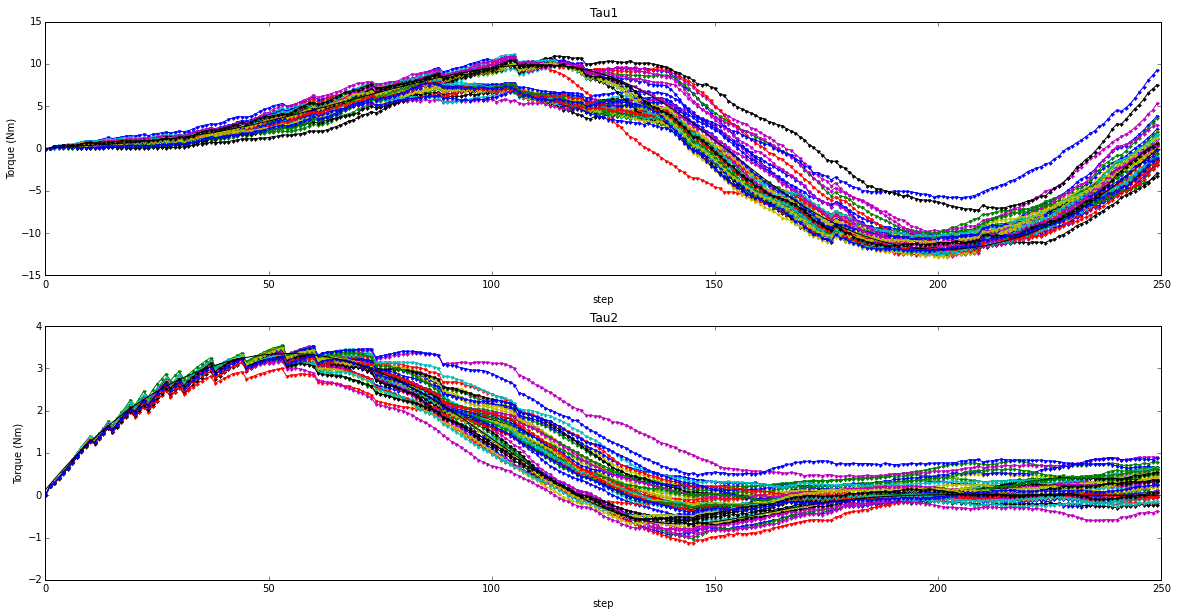

In [57]:
tji=1
torques_original = numpy.array([torques_all_1[(tji-1)*250:(tji)*250],torques_all_2[(tji-1)*250:(tji)*250]])
x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji)
ymin = numpy.array([torques_all_1.min(),torques_all_2.min()]).min()
ymax = numpy.array([torques_all_1.max(),torques_all_2.max()]).max()

noiselevel=0
decimationlevel=1
# run_number=1

torques_read_1=numpy.zeros((50,250))
torques_read_2=numpy.zeros((50,250))

plt.figure(figsize =(20,10))
plt.subplot(2,1,1)
for run_number in range(1,51):
    torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    torques_read_1[run_number-1] = numpy.copy(torques[:,0])
    plt.plot(torques[:,0],'.-',label="Tau1 Calculated")
plt.plot(torques_original[0,:],'k-',label="Tau1 Original")
plt.ylabel("Torque (Nm)")
plt.xlabel("step")
plt.title("Tau1")
plt.xlim(0,250)
# plt.legend()

plt.subplot(2,1,2)
for run_number in range(1,51):
    torques = slf.load_from_file("./"+base_dir+"/"+sim_set+"/torques_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    torques_read_2[run_number-1] = numpy.copy(torques[:,1])
    plt.plot(torques[:,1],'.-',label="Tau2 Calculated")
plt.plot(torques_original[1,:],'k-',label="Tau2 Original")
plt.xlim(0,250)
plt.ylabel("Torque (Nm)")
plt.xlabel("step")
plt.title("Tau2")
# plt.ylim(ymin,ymax)
# plt.legend()

plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_all_"+str(tji)+".pdf")
plt.show()

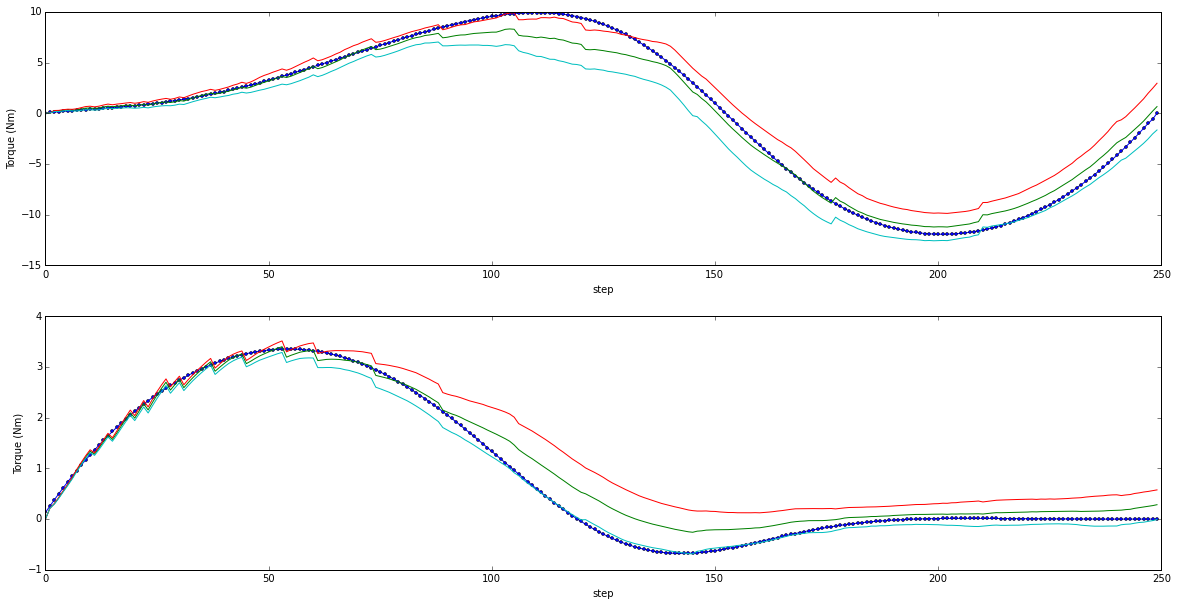

In [58]:
plt.figure(figsize =(20,10))
plt.subplot(211)
plt.plot(torques_original[0,:],'o-', markersize=3,label="Tau1 Original")
plt.plot(torques_read_1.mean(axis=0),label="Tau1 Mean Value")
plt.plot(torques_read_1.mean(axis=0)+torques_read_1.std(axis=0),label="Tau1 +1SD")
plt.plot(torques_read_1.mean(axis=0)-torques_read_1.std(axis=0),label="Tau1 -1SD")
plt.ylabel("Torque (Nm)")
plt.xlabel("step")

plt.subplot(212)
plt.plot(torques_original[1,:],'o-',label="Tau2 Original", markersize=3)
plt.plot(torques_read_2.mean(axis=0))
plt.plot(torques_read_2.mean(axis=0)+torques_read_2.std(axis=0),label="Tau1 +1SD")
plt.plot(torques_read_2.mean(axis=0)-torques_read_2.std(axis=0),label="Tau1 -1SD")
plt.ylabel("Torque (Nm)")
plt.xlabel("step")

plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_mean_std_"+str(tji)+".pdf")
plt.show()

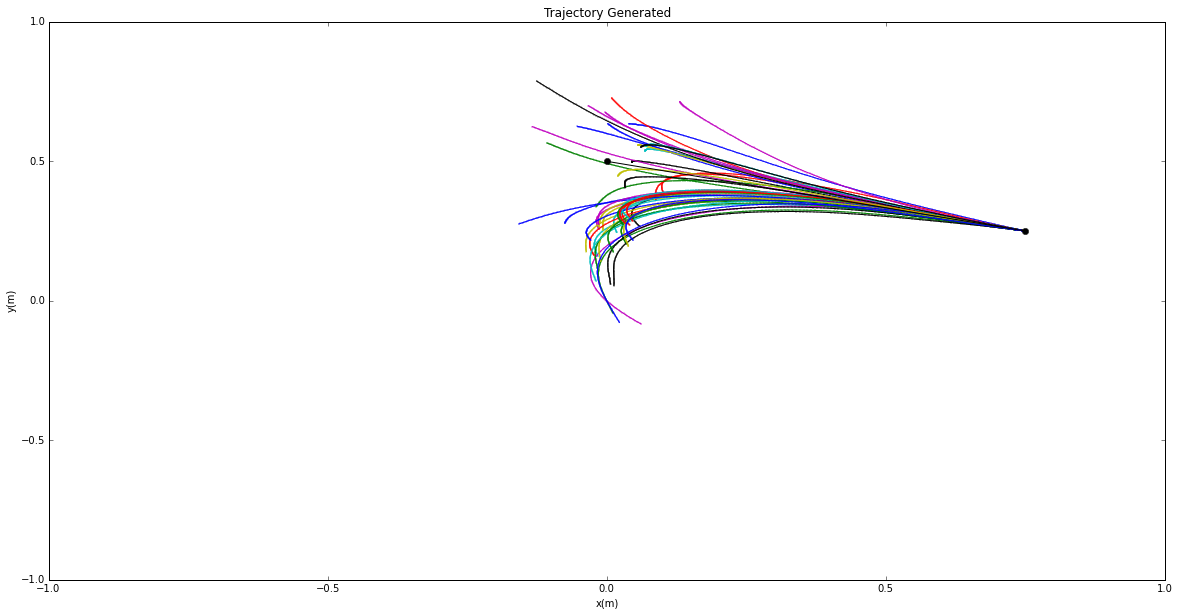

In [59]:
plt.figure(figsize =(20,10))
for run_number in range(1,51):
    teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    H,E = joints_to_hand(teta,aparams)
    plt.plot(H[:,0],H[:,1],'.-',markersize=1)
plt.plot([xstart,xdest],[ystart,ydest],'ko-')
plt.xlim(numpy.array([xstart,xdest]).min()-0.1,numpy.array([xstart,xdest]).max()+0.1)
plt.ylim(numpy.array([ystart,ydest]).min()-0.1,numpy.array([ystart,ydest]).max()+0.1)
plt.title("Trajectory Generated")
plt.xlabel("x(m)")
plt.ylabel("y(m)")
# plt.savefig("NRMSE_test__traj_bad.pdf")
plt.xlim(-1,1)
plt.ylim(-1,1)
# plt.xlim(-.14,-.06)
# plt.ylim(0.1,.8)
plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_trajectory_"+str(tji)+".pdf")
plt.show()

In [33]:
t_mov=numpy.arange(0, .5, 2.0/1000) # t starts in 0s and steps time_step(s) until reaches MT(s)
x_lsm,y_lsm,xstart,ystart,xdest,ydest = generates_lsm_start(tji)

# Generates the movements according to:
# Flash, Tamar, and Neville Hogan. 1985
H_path=cartesian_movement_generation_training(xstart, ystart, xdest, ydest, .5, t_mov)

In [34]:
metric_traj = []
for run_number in range(1,51):
    teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    H,E = joints_to_hand(teta,aparams)
    metric_traj.append(MY_METRIC(numpy.array([H_path[:,0],H_path[:,1]]),numpy.array([H[:,0][:len(H_path[:,0])],H[:,1][:len(H_path[:,0])]])))
    
metric_traj=numpy.array(metric_traj)

metric_traj

array([ 0.08473506,  0.00933774,  0.04399679,  0.01255217,  0.04471888,
        0.08516723,  0.03931047,  0.04050143,  0.0308968 ,  0.08110746,
        0.02531113,  0.02186083,  0.02419732,  0.12513978,  0.03699992,
        0.0241019 ,  0.03208507,  0.03096594,  0.06827833,  0.02030152,
        0.01240749,  0.02075305,  0.11478846,  0.07882373,  0.11660121,
        0.12995404,  0.05469323,  0.03454902,  0.03724529,  0.11545637,
        0.02302199,  0.01738552,  0.02454296,  0.0329438 ,  0.04324304,
        0.07703945,  0.08623395,  0.01798047,  0.04476189,  0.03793766,
        0.02324268,  0.03350972,  0.13187103,  0.12237557,  0.01945821,
        0.01872201,  0.04100901,  0.01905944,  0.04878224,  0.03049101])

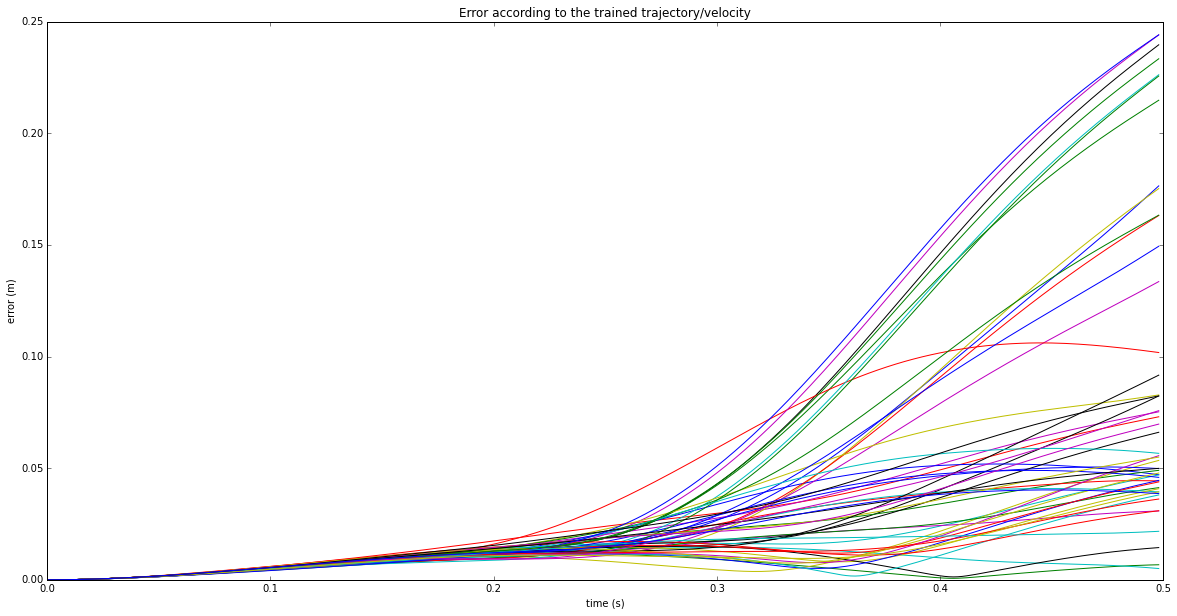

In [35]:
plt.figure(figsize =(20,10))
for run_number in range(1,51):
    teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    H,E = joints_to_hand(teta,aparams)
    v1,v2=numpy.array([H_path[:,0],H_path[:,1]]),numpy.array([H[:,0][:len(H_path[:,0])],H[:,1][:len(H_path[:,0])]])
    plt.plot(t_mov,numpy.sqrt(((v2-v1)**2).sum(axis=0)))
plt.ylabel("error (m)")
plt.xlabel("time (s)")
plt.title("Error according to the trained trajectory/velocity")
plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_error_"+str(tji)+".pdf")
plt.show()

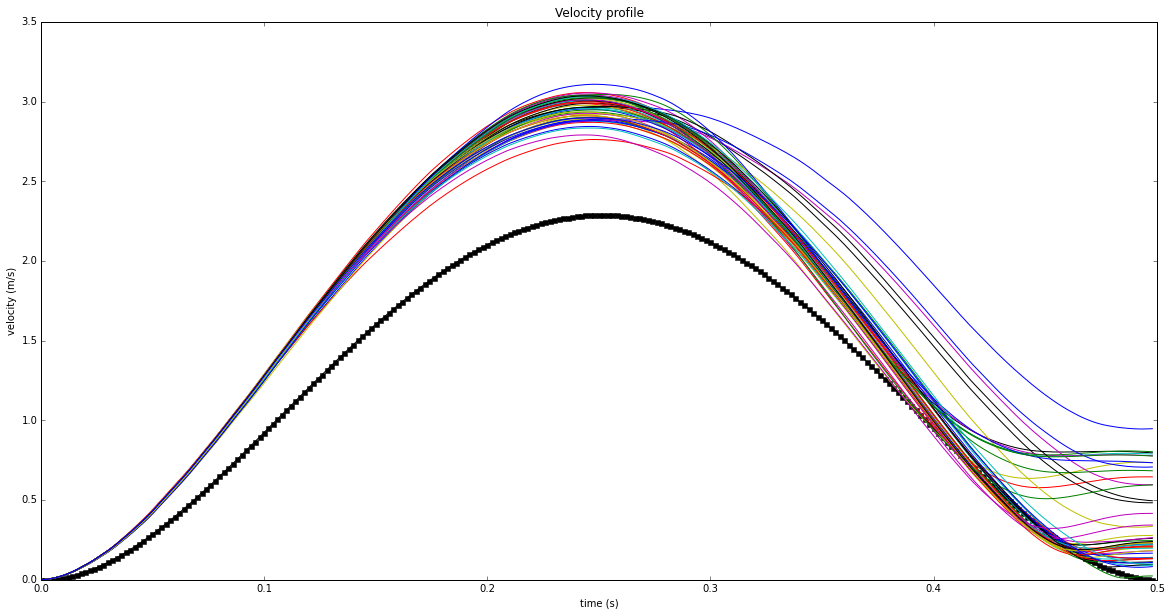

In [32]:
plt.figure(figsize =(20,10))

plt.plot(t_mov,numpy.sqrt(numpy.concatenate(([0], derivator(H_path[:,0],t_mov)))**2+numpy.concatenate(([0], derivator(H_path[:,1],t_mov)))**2),'ks-',markersize=5, label="Resultant Velocity Vector")
for run_number in range(1,51):
    teta = slf.load_from_file("./"+base_dir+"/"+sim_set+"/teta_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")
    H,E = joints_to_hand(teta,aparams)
    plt.plot(t_mov,numpy.sqrt(numpy.concatenate(([0], derivator(H[:,0],t_mov)))**2+numpy.concatenate(([0], derivator(H[:,1],t_mov)))**2),label="Resultant Velocity Vector")
plt.title("Velocity profile")
plt.ylabel("velocity (m/s)")
plt.xlabel("time (s)")
plt.savefig(os.getcwd()+"/"+base_dir+"/"+sim_set+"/readout_testing_velocity_"+str(tji)+".pdf")
plt.show()

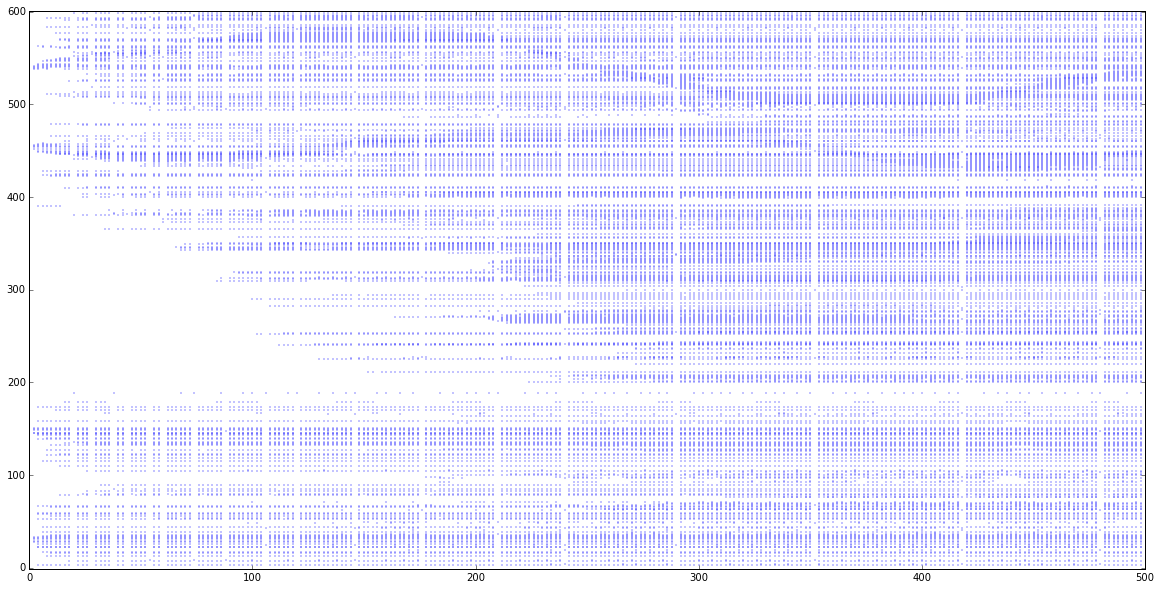

In [26]:

OutputSpks_save = slf.load_from_file("./"+base_dir+"/"+sim_set+"/OutputSpks_save_"+str(tji)+"_noise_level_"+str(noiselevel)+"_killed_neurons_"+str(decimationlevel)+"_run_"+str(run_number)+".pickles")

y = numpy.array([j for i in OutputSpks_save for j in i[0]])
x = numpy.array([i[1] for i in OutputSpks_save for j in i[0]])

plt.figure(figsize =(20,10))
plt.plot(x*1000,y,'.',markersize=1)
# plt.xlim(-1,251)
plt.ylim(-1,601)
plt.show()